In [49]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [50]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
print(DATA_PATH)
TEST_DATASET_PATH = os.path.join(DATA_PATH, 'test')
TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'train')
OUTPUT_PATH = os.path.join(DATA_PATH, 'segmented_train')
SEGMENTED_TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'segmented_train')
AUGMENTED_SEGMENTED_TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'augmented_segmented_train')

C:\Users\see_w\Downloads\data


In [51]:
def dilate(image, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    dilation = cv2.dilate(image, kernel, iterations=1)
    return dilation

def erode(image, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    erosion = cv2.erode(image, kernel, iterations=1)
    return erosion

def gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2):
    blur = cv2.GaussianBlur(image, kernel, 0)
    thresholded_image = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, blockSize=block_size, C=C
    )
    return thresholded_image


def combine_boxes(box1, box2):
    """Combine two overlapping boxes into a single box."""
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[0] + box1[2], box2[0] + box2[2])
    y2 = max(box1[1] + box1[3], box2[1] + box2[3])

    # Return combined box
    return (x1, y1, x2 - x1, y2 - y1)

def boxes_overlap(box1, box2):
    """Check if two boxes overlap."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def non_max_suppression(boxes):
    """Combine overlapping boxes."""
    if len(boxes) == 0:
        return []

    boxes = sorted(boxes, key=lambda box: box[0])  # Sort by x-coordinate
    combined_boxes = []

    while boxes:
        current_box = boxes.pop(0)
        to_merge = []

        # Check for boxes that overlap with current_box and merge them
        for box in boxes:
            if boxes_overlap(current_box, box):  # Check if they overlap
                to_merge.append(box)

        # Combine all overlapping boxes into one
        for box in to_merge:
            current_box = combine_boxes(current_box, box)
            boxes.remove(box)

        combined_boxes.append(current_box)

    return combined_boxes

def extract_contours(image, min_height=10):
    """Extract contours and return bounding boxes."""
    inverted_image = cv2.bitwise_not(image)
    contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding boxes and filter by height
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours if cv2.boundingRect(contour)[3] > min_height]

    return bounding_boxes

def segment_characters(image):
    """Segment the CAPTCHA image into individual characters using NMS."""
    # Step 1: Extract bounding boxes from contours
    bounding_boxes = extract_contours(image)

    # Step 2: Apply Non-Maximum Suppression (NMS) to remove overlapping boxes
    nms_boxes = non_max_suppression(bounding_boxes)

    # Step 3: Create tuples of (x_coordinate, box, char_image) to maintain correct order
    char_info = []
    for box in nms_boxes:
        x, y, w, h = box
        char_image = image[y:y+h, x:x+w]
        char_info.append((x, box, char_image))

    # Step 4: Sort by x-coordinate and extract ordered images
    char_info.sort(key=lambda x: x[0])  # Sort by x-coordinate
    nms_boxes = [info[1] for info in char_info]  # Keep boxes in same order
    char_images = [info[2] for info in char_info]  # Keep images in same order

    return nms_boxes, char_images # nms_boxes is used for plotting

In [52]:
def preprocess_image(image):
    image = cv2.bitwise_not(image)
    image = erode(image, kernel_size=(2, 2))
    image = cv2.bitwise_not(image)
    image = gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2)
    image = erode(image, kernel_size=(2, 2))
    image = gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2)
    image = erode(image, kernel_size=(2, 2))
    return image

def process_and_save_images(input_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Keep track of how many captchas were skipped
    skipped_count = 0

    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        if not filename.endswith('.png'):
            continue

        # Extract the true label from the filename
        base_name = filename.split('-')[0]

        # Load the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Apply preprocessing steps
        image = preprocess_image(image)

        # Segment characters
        _, char_images = segment_characters(image)

        # Validate the number of segmented parts
        if len(char_images) != len(base_name):
            print(f"Skipping {filename}: Expected {len(base_name)} parts, got {len(char_images)}.")
            skipped_count += 1
            continue  # Skip saving this image

        # Save each segmented character follow the naming convention <label_str>-<char>.png
        for idx, char_img in enumerate(char_images):
            char_label = base_name[idx]
            save_name = f"{base_name}-{char_label}.png"
            save_path = os.path.join(output_dir, save_name)

            # Save the segmented character
            cv2.imwrite(save_path, char_img)

    print(f"Processing complete! Segmented characters are saved in {output_dir}")
    print(f"Total skipped: {skipped_count}")

process_and_save_images(TRAIN_DATASET_PATH, SEGMENTED_TRAIN_DATASET_PATH)

Skipping 00fh-0.png: Expected 4 parts, got 0.
Skipping 010b-0.png: Expected 4 parts, got 6.
Skipping 010ud-0.png: Expected 5 parts, got 1.
Skipping 02cc-0.png: Expected 4 parts, got 2.
Skipping 06rh65-0.png: Expected 6 parts, got 5.
Skipping 06xg-0.png: Expected 4 parts, got 5.
Skipping 06yx8nkv-0.png: Expected 8 parts, got 7.
Skipping 07smvpl-0.png: Expected 7 parts, got 8.
Skipping 08mse1o-0.png: Expected 7 parts, got 9.
Skipping 08xj75-0.png: Expected 6 parts, got 7.
Skipping 0axhfa-0.png: Expected 6 parts, got 4.
Skipping 0bcjvo4p-0.png: Expected 8 parts, got 9.
Skipping 0d0vp1-0.png: Expected 6 parts, got 5.
Skipping 0duo1r-0.png: Expected 6 parts, got 2.
Skipping 0dw9b7hd-0.png: Expected 8 parts, got 7.
Skipping 0fm4a3rx-0.png: Expected 8 parts, got 12.
Skipping 0h7htrjq-0.png: Expected 8 parts, got 5.
Skipping 0hox6-0.png: Expected 5 parts, got 2.
Skipping 0hs60bw-0.png: Expected 7 parts, got 5.
Skipping 0iee8z9-0.png: Expected 7 parts, got 6.
Skipping 0ihk7bk-0.png: Expected 7 

Skipping 41ufgg-0.png: Expected 6 parts, got 14.
Skipping 422g0b-0.png: Expected 6 parts, got 8.
Skipping 42o75-0.png: Expected 5 parts, got 6.
Skipping 43u1voui-0.png: Expected 8 parts, got 4.
Skipping 444kmpf-0.png: Expected 7 parts, got 6.
Skipping 444z9exx-0.png: Expected 8 parts, got 7.
Skipping 447hq49-0.png: Expected 7 parts, got 3.
Skipping 449ftp-0.png: Expected 6 parts, got 7.
Skipping 44y4ih3-0.png: Expected 7 parts, got 4.
Skipping 45p9d-0.png: Expected 5 parts, got 4.
Skipping 463o-0.png: Expected 4 parts, got 3.
Skipping 47a48re-0.png: Expected 7 parts, got 8.
Skipping 480c-0.png: Expected 4 parts, got 2.
Skipping 4bbd15-0.png: Expected 6 parts, got 7.
Skipping 4bjtet-0.png: Expected 6 parts, got 5.
Skipping 4bkgh-0.png: Expected 5 parts, got 4.
Skipping 4bm3-0.png: Expected 4 parts, got 3.
Skipping 4c0booxn-0.png: Expected 8 parts, got 7.
Skipping 4dmk7-0.png: Expected 5 parts, got 6.
Skipping 4ft9k7qn-0.png: Expected 8 parts, got 0.
Skipping 4fw61vc-0.png: Expected 7 pa

Skipping 82gu-0.png: Expected 4 parts, got 3.
Skipping 82nr-0.png: Expected 4 parts, got 3.
Skipping 8663ssg-0.png: Expected 7 parts, got 4.
Skipping 86gf-0.png: Expected 4 parts, got 2.
Skipping 86il2ko-0.png: Expected 7 parts, got 5.
Skipping 88iaqi-0.png: Expected 6 parts, got 8.
Skipping 8aap-0.png: Expected 4 parts, got 3.
Skipping 8cahjsap-0.png: Expected 8 parts, got 9.
Skipping 8ce92-0.png: Expected 5 parts, got 7.
Skipping 8f7i-0.png: Expected 4 parts, got 3.
Skipping 8ff3g25-0.png: Expected 7 parts, got 6.
Skipping 8gr6z-0.png: Expected 5 parts, got 4.
Skipping 8iyt-0.png: Expected 4 parts, got 2.
Skipping 8jbtjs-0.png: Expected 6 parts, got 7.
Skipping 8kghth-0.png: Expected 6 parts, got 7.
Skipping 8l61-0.png: Expected 4 parts, got 3.
Skipping 8l8hmh-0.png: Expected 6 parts, got 8.
Skipping 8mfai4-0.png: Expected 6 parts, got 5.
Skipping 8nogbc-0.png: Expected 6 parts, got 3.
Skipping 8o8379d-0.png: Expected 7 parts, got 3.
Skipping 8ojtnpc-0.png: Expected 7 parts, got 6.
S

Skipping ctumzv55-0.png: Expected 8 parts, got 9.
Skipping cuc3nw-0.png: Expected 6 parts, got 4.
Skipping cue7ii-0.png: Expected 6 parts, got 5.
Skipping cur2rqt-0.png: Expected 7 parts, got 1.
Skipping cusx9f-0.png: Expected 6 parts, got 1.
Skipping cwa10k7-0.png: Expected 7 parts, got 2.
Skipping cx2ysb-0.png: Expected 6 parts, got 10.
Skipping cxg7v56v-0.png: Expected 8 parts, got 11.
Skipping d2lc-0.png: Expected 4 parts, got 5.
Skipping d5ri1u-0.png: Expected 6 parts, got 3.
Skipping d6147s-0.png: Expected 6 parts, got 9.
Skipping d6564x-0.png: Expected 6 parts, got 2.
Skipping d6f5y7-0.png: Expected 6 parts, got 1.
Skipping d6vw-0.png: Expected 4 parts, got 1.
Skipping d7og1ctz-0.png: Expected 8 parts, got 7.
Skipping d8dy-0.png: Expected 4 parts, got 3.
Skipping daqbbg84-0.png: Expected 8 parts, got 6.
Skipping db1htemj-0.png: Expected 8 parts, got 9.
Skipping dba526yt-0.png: Expected 8 parts, got 9.
Skipping dbz24514-0.png: Expected 8 parts, got 5.
Skipping dcxc-0.png: Expecte

Skipping hgdikcb-0.png: Expected 7 parts, got 6.
Skipping hgjwswrc-0.png: Expected 8 parts, got 6.
Skipping hgvkx-0.png: Expected 5 parts, got 4.
Skipping hhk7sx-0.png: Expected 6 parts, got 4.
Skipping hhm4t7h-0.png: Expected 7 parts, got 3.
Skipping hi1vi-0.png: Expected 5 parts, got 4.
Skipping hiczvfiu-0.png: Expected 8 parts, got 7.
Skipping hihs-0.png: Expected 4 parts, got 0.
Skipping hjpy-0.png: Expected 4 parts, got 3.
Skipping houb-0.png: Expected 4 parts, got 3.
Skipping hp48uegi-0.png: Expected 8 parts, got 4.
Skipping htd6-0.png: Expected 4 parts, got 2.
Skipping htwa-0.png: Expected 4 parts, got 3.
Skipping hu3d0c-0.png: Expected 6 parts, got 7.
Skipping hvfoyp9c-0.png: Expected 8 parts, got 7.
Skipping hvr23pm-0.png: Expected 7 parts, got 4.
Skipping hw0vz5j1-0.png: Expected 8 parts, got 12.
Skipping hwagcn-0.png: Expected 6 parts, got 5.
Skipping hwq0huvj-0.png: Expected 8 parts, got 4.
Skipping hwxmjb-0.png: Expected 6 parts, got 5.
Skipping hx9ddji-0.png: Expected 7 p

Skipping llsjx0v9-0.png: Expected 8 parts, got 7.
Skipping lmnmuq-0.png: Expected 6 parts, got 9.
Skipping lnpaql-0.png: Expected 6 parts, got 5.
Skipping lphl360-0.png: Expected 7 parts, got 4.
Skipping lquft3d-0.png: Expected 7 parts, got 6.
Skipping lrg3mj46-0.png: Expected 8 parts, got 0.
Skipping lu9xlcb-0.png: Expected 7 parts, got 6.
Skipping lv64wfq-0.png: Expected 7 parts, got 5.
Skipping lw86q-0.png: Expected 5 parts, got 3.
Skipping lwb4u4f-0.png: Expected 7 parts, got 9.
Skipping lwtl-0.png: Expected 4 parts, got 5.
Skipping lxdp-0.png: Expected 4 parts, got 2.
Skipping lxmnbuk-0.png: Expected 7 parts, got 6.
Skipping ly3bvt-0.png: Expected 6 parts, got 5.
Skipping lyjy-0.png: Expected 4 parts, got 1.
Skipping m1el7ggi-0.png: Expected 8 parts, got 9.
Skipping m238i-0.png: Expected 5 parts, got 4.
Skipping m31nh-0.png: Expected 5 parts, got 6.
Skipping m339-0.png: Expected 4 parts, got 3.
Skipping m4ov4-0.png: Expected 5 parts, got 6.
Skipping m6d0ul-0.png: Expected 6 parts,

Skipping pd7tcd12-0.png: Expected 8 parts, got 7.
Skipping pdpkbaxg-0.png: Expected 8 parts, got 0.
Skipping pdvo1eu-0.png: Expected 7 parts, got 6.
Skipping pebs8msl-0.png: Expected 8 parts, got 6.
Skipping pemle5r-0.png: Expected 7 parts, got 10.
Skipping pfc31kc-0.png: Expected 7 parts, got 6.
Skipping pfx5-0.png: Expected 4 parts, got 5.
Skipping ph54m3-0.png: Expected 6 parts, got 5.
Skipping ph9yr-0.png: Expected 5 parts, got 3.
Skipping pi6x-0.png: Expected 4 parts, got 3.
Skipping pj1svxla-0.png: Expected 8 parts, got 3.
Skipping pk7d-0.png: Expected 4 parts, got 3.
Skipping plelck-0.png: Expected 6 parts, got 3.
Skipping pm9yyl8-0.png: Expected 7 parts, got 1.
Skipping pme8-0.png: Expected 4 parts, got 3.
Skipping pooqawbn-0.png: Expected 8 parts, got 6.
Skipping pq3nng-0.png: Expected 6 parts, got 9.
Skipping pqadfz-0.png: Expected 6 parts, got 5.
Skipping pqljg-0.png: Expected 5 parts, got 6.
Skipping pqr7-0.png: Expected 4 parts, got 2.
Skipping pqw4akqd-0.png: Expected 8 p

Skipping tyldcuq-0.png: Expected 7 parts, got 6.
Skipping tzbi0-0.png: Expected 5 parts, got 4.
Skipping u1a1g-0.png: Expected 5 parts, got 4.
Skipping u1x2-0.png: Expected 4 parts, got 5.
Skipping u1xqt-0.png: Expected 5 parts, got 4.
Skipping u5rx8w4-0.png: Expected 7 parts, got 5.
Skipping u5v4xaxl-0.png: Expected 8 parts, got 7.
Skipping u5zba0-0.png: Expected 6 parts, got 5.
Skipping u7d96-0.png: Expected 5 parts, got 1.
Skipping u7npos0c-0.png: Expected 8 parts, got 7.
Skipping u7pu-0.png: Expected 4 parts, got 5.
Skipping u81wurpa-0.png: Expected 8 parts, got 7.
Skipping u89h-0.png: Expected 4 parts, got 1.
Skipping u8ei-0.png: Expected 4 parts, got 5.
Skipping u8lwt7-0.png: Expected 6 parts, got 8.
Skipping u9ggdq-0.png: Expected 6 parts, got 3.
Skipping u9hkbjog-0.png: Expected 8 parts, got 6.
Skipping uah0-0.png: Expected 4 parts, got 2.
Skipping uaqmlp-0.png: Expected 6 parts, got 5.
Skipping ubwtip-0.png: Expected 6 parts, got 2.
Skipping uct5592j-0.png: Expected 8 parts, g

Skipping y9om70-0.png: Expected 6 parts, got 3.
Skipping yaxwtssg-0.png: Expected 8 parts, got 0.
Skipping ycgxhwu6-0.png: Expected 8 parts, got 7.
Skipping yf1skt-0.png: Expected 6 parts, got 5.
Skipping yfkx4v1-0.png: Expected 7 parts, got 6.
Skipping ygaju-0.png: Expected 5 parts, got 3.
Skipping ygir7b-0.png: Expected 6 parts, got 5.
Skipping yj8alup-0.png: Expected 7 parts, got 4.
Skipping yjshxc-0.png: Expected 6 parts, got 1.
Skipping ylby0t0a-0.png: Expected 8 parts, got 5.
Skipping yml9m-0.png: Expected 5 parts, got 3.
Skipping ymva5s55-0.png: Expected 8 parts, got 9.
Skipping yo4y5o28-0.png: Expected 8 parts, got 11.
Skipping yof332no-0.png: Expected 8 parts, got 9.
Skipping yps8t-0.png: Expected 5 parts, got 3.
Skipping yq85o-0.png: Expected 5 parts, got 4.
Skipping yqeg-0.png: Expected 4 parts, got 5.
Skipping yr4xwi5h-0.png: Expected 8 parts, got 6.
Skipping yrqm-0.png: Expected 4 parts, got 3.
Skipping ysd1x7xl-0.png: Expected 8 parts, got 5.
Skipping ysqhhiqa-0.png: Expe

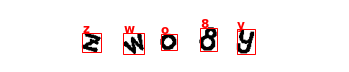

In [53]:
## plot image and bounding boxes
def plot_image(image, boxes, labels):
    """Plot image with bounding boxes."""
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    for box in boxes:
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ## add label
        ax.text(x, y, labels[boxes.index(box)], color='r', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

sample = 'zwo8y-0.png'
image = cv2.imread(os.path.join(TRAIN_DATASET_PATH, sample), cv2.IMREAD_GRAYSCALE)
image = preprocess_image(image)
boxes, char_images = segment_characters(image)
base_name = sample.split('-')[0]
plot_image(image, boxes, base_name)

In [54]:
def augment_and_save_images(input_dir, output_dir, augment_count=3):
    """Augment images from `input_dir` and save them with proper naming to `output_dir`."""
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    # Define a more controlled data augmentation pipeline
    datagen = ImageDataGenerator(
        rotation_range=10,          # Small rotation for better quality
        width_shift_range=0.05,     # Slight horizontal shift
        height_shift_range=0.05,    # Slight vertical shift
        shear_range=0.1,            # Mild shearing
        zoom_range=0.1,             # Mild zoom
        fill_mode='nearest'         # Avoid introducing artifacts
    )

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if not filename.endswith('.png'):
            continue
        
        # Load the original image
        image_path = os.path.join(input_dir, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Expand dimensions for augmentation
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = np.expand_dims(img, axis=0)   # Add batch dimension

        # Extract the base filename without extension (e.g., 'abc-o')
        base_name = filename.split('.')[0]

        # Generate and save augmented images
        for i, batch in enumerate(datagen.flow(img, batch_size=1)):
            # Save each augmented image with proper naming
            augmented_filename = f"{base_name}-{i + 1}.png"
            augmented_path = os.path.join(output_dir, augmented_filename)

            # Save the augmented image
            cv2.imwrite(augmented_path, batch[0].squeeze().astype(np.uint8))

            # Stop after generating `augment_count` images per original image
            if i + 1 >= augment_count:
                break

    print(f"Augmentation complete! Augmented images saved in {output_dir}")


# Example usage
input_dir = SEGMENTED_TRAIN_DATASET_PATH
output_dir = AUGMENTED_SEGMENTED_TRAIN_DATASET_PATH
augment_and_save_images(input_dir, output_dir)

Augmentation complete! Augmented images saved in C:\Users\see_w\Downloads\data\augmented_segmented_train


In [55]:
from sklearn.model_selection import train_test_split

output_dir = AUGMENTED_SEGMENTED_TRAIN_DATASET_PATH

# Define character set (e.g., 0-9, a-z)
CHAR_SET = "0123456789abcdefghijklmnopqrstuvwxyz"
CHAR_TO_IDX = {char: idx for idx, char in enumerate(CHAR_SET)}

def load_dataset(data_dir):
    images = []
    labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):
            # Extract the character from the filename (e.g., 'o' from 'oq1j-o.png')
            char_label = filename.split('-')[1][0]

            if char_label in CHAR_TO_IDX:
                # Load the image in grayscale
                image_path = os.path.join(data_dir, filename)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize to 28x28 (if needed)
                img = cv2.resize(img, (28, 28))
                img = img / 255.0  # Normalize pixel values to [0, 1]

                # Store the image and label
                images.append(img)
                labels.append(CHAR_TO_IDX[char_label])

    # Convert to numpy arrays
    images = np.array(images).reshape(-1, 28, 28, 1)  # Add channel dimension
    labels = np.array(labels)

    return images, labels

# Load the dataset
images, labels = load_dataset(output_dir)
print(f"Loaded {len(images)} images with {len(set(labels))} unique labels.")

Loaded 107817 images with 36 unique labels.


In [56]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")

Training set size: 86253, Validation set size: 21564


In [ ]:
#MODEL 1 ~8%

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# def build_model(num_classes):
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         MaxPooling2D((2, 2)),
#         Dropout(0.2),

#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Dropout(0.2),

#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(num_classes, activation='softmax')
#     ])

#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Build the model for 36 classes (0-9, a-z)
# num_classes = len(CHAR_SET)
# model = build_model(num_classes)
# model.summary()

In [ ]:
#MODEL 2 ~24%

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, ReLU

# def build_custom_cnn(num_classes):
#     model = Sequential()

#     # First Conv Block
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Second Conv Block
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Third Conv Block
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Fully Connected Layers
#     model.add(Flatten())
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(36, activation='softmax'))  # 36 classes: 0-9 + a-z

#     # Compile the model
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model


# num_classes = len(CHAR_SET)
# model = build_model(num_classes)
# model.summary()


In [12]:
#MODEL 3 ~33% (AlexNet)

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU

# def build_alexnet():
#     model = Sequential()

#     # 1st Convolutional Layer
#     model.add(Conv2D(64, (3, 3), strides=1, padding='same', input_shape=(28, 28, 1)))
#     model.add(BatchNormalization())
#     model.add(ReLU())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # 2nd Convolutional Layer
#     model.add(Conv2D(128, (3, 3), strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(ReLU())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # 3rd Convolutional Layer
#     model.add(Conv2D(256, (3, 3), strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(ReLU())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Flatten the output for Fully Connected Layers
#     model.add(Flatten())

#     # 1st Fully Connected Layer
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))

#     # 2nd Fully Connected Layer
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))

#     # Output Layer
#     model.add(Dense(36, activation='softmax'))

#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model

# model = build_alexnet()
# model.summary()

In [57]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_crnn_model(input_shape=(28, 28, 1), num_classes=36, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    # Adding a Dropout layer after convolutional layers
    x = layers.Dropout(dropout_rate)(x)

    # Calculate the new shape
    height = x.shape[1]  # height after convolution and pooling
    width = x.shape[2]   # width after convolution and pooling
    channels = x.shape[3]  # channels after convolution
    new_shape = (height, width * channels)  # Reshape to (time_steps, features)

    # Reshape for LSTM input
    x = layers.Reshape(target_shape=new_shape)(x)

    # Recurrent layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(dropout_rate)(x)  # Adding dropout after the first LSTM

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    x = layers.Dropout(dropout_rate)(x)  # Adding dropout after the second LSTM

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the CRNN model
model = build_crnn_model()
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0   

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3
)

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
1348/1348 [==============================] - 69s 46ms/step - loss: 1.9480 - accuracy: 0.4491 - val_loss: 0.7981 - val_accuracy: 0.7590
Epoch 2/100
1348/1348 [==============================] - 53s 39ms/step - loss: 0.8783 - accuracy: 0.7413 - val_loss: 0.6741 - val_accuracy: 0.7936
Epoch 3/100
1348/1348 [==============================] - 49s 37ms/step - loss: 0.7420 - accuracy: 0.7776 - val_loss: 0.6268 - val_accuracy: 0.8050
Epoch 4/100
1348/1348 [==============================] - 68s 51ms/step - loss: 0.6695 - accuracy: 0.7947 - val_loss: 0.5787 - val_accuracy: 0.8204
Epoch 5/100
1348/1348 [==============================] - 62s 46ms/step - loss: 0.6187 - accuracy: 0.8096 - val_loss: 0.5471 - val_accuracy: 0.8305
Epoch 6/100
1348/1348 [==============================] - 52s 38ms/step - loss: 0.5697 - accuracy: 0.8218 - val_loss: 0.5300 - val_accuracy: 0.8374
Epoch 7/100
1348/1348 [==============================] - 51s 38ms/step - loss: 0.5407 - accuracy: 0.8299 - val_loss: 0

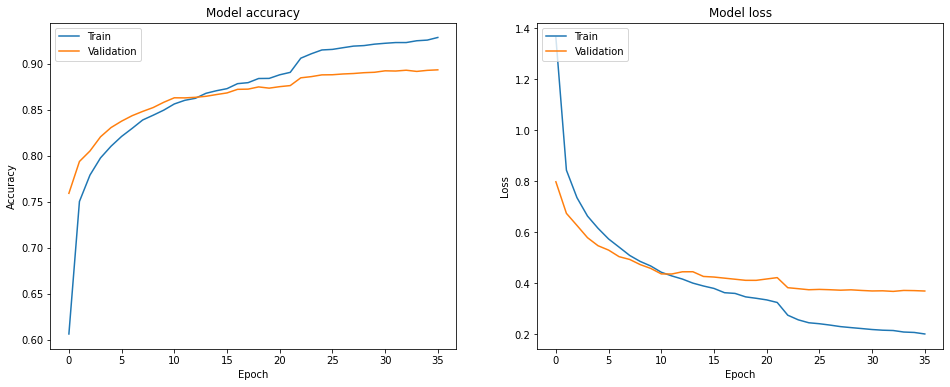

In [59]:
# Convert to a DataFrame
import pandas as pd
history_df = pd.DataFrame(history.history)

# Visualize the History

import matplotlib.pyplot as plt

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training & validation accuracy values
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history_df)

In [60]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

674/674 [==============================] - 8s 12ms/step - loss: 0.3679 - accuracy: 0.8927
Validation Accuracy: 89.27%


In [61]:
# Save the trained model
def save_model(model, dir_path, model_name="character_recognition_model.h5"):
    # Ensure the directory exists
    os.makedirs(dir_path, exist_ok=True)

    # Create the full path to the model file
    model_path = os.path.join(dir_path, model_name)

    # Save the model
    model.save(model_path)
    print(f"Model saved successfully at: {model_path}")

# Example usage
save_dir = os.path.join(DATA_PATH, 'models')
save_model(model, save_dir, 'crnn_89.keras')

Model saved successfully at: C:\Users\see_w\Downloads\data\models\crnn_89.keras


In [62]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
MODEL_PATH = os.path.join(DATA_PATH, 'models', 'crnn_89.keras')
model = load_model(MODEL_PATH)

# Define the character set used during training
CHAR_SET = "0123456789abcdefghijklmnopqrstuvwxyz"
CHAR_MAP = {idx: char for idx, char in enumerate(CHAR_SET)}


def predict_character(image, model):
    """Predict a single character using the trained model."""
    img = cv2.resize(image, (28, 28)) / 255.0  # Resize and normalize
    img = np.expand_dims(img, axis=[0, -1])  # Add batch and channel dimensions

    prediction = model.predict(img)
    predicted_label = np.argmax(prediction)
    predicted_char = CHAR_MAP[predicted_label]
    return predicted_char

def predict_captcha_string(image_path, model):
    """Predict the entire CAPTCHA string from the input image."""
    # Load the image
    image_path = os.path.join(input_dir, image_path)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Preprocess the image
    processed_image = preprocess_image(image)

    # Segment the characters
    _, char_images = segment_characters(processed_image)

    # Predict each character and reconstruct the string
    predicted_string = ""
    for char_img in char_images:
        predicted_char = predict_character(char_img, model)
        predicted_string += predicted_char

    return predicted_string

# Example usage
captcha_image_path = os.path.join(TEST_DATASET_PATH, "2d76-0.png")
predicted_string = predict_captcha_string(captcha_image_path, model)
print(f"Predicted CAPTCHA string: {predicted_string}")


Predicted CAPTCHA string: 2d76


True: x2xk02p, Predicted: x2xk02p
True: 63zdn, Predicted: 63zdn
True: ns45, Predicted: m45
True: ghdb, Predicted: ghdb
True: n4pkksmh, Predicted: n4pkkshh
True: mrmth, Predicted: mrmth
True: h7f9, Predicted: h7f9
True: v4ua, Predicted: v4ua
True: 153tt0, Predicted: 63tto
True: nlha0, Predicted: nlhad
True: 0wla, Predicted: q34
True: n7tp, Predicted: m7tp
True: k397f, Predicted: k397f
True: a3lb, Predicted: a3lb
True: 6jgczv, Predicted: 1l
True: 4orw5, Predicted: 40rw5
True: ddq99w, Predicted: ddq99w
True: 2d76, Predicted: 2d76
True: to0d56, Predicted: tqods6
True: wxw2g9o, Predicted: wtw2g9o
True: bzx2, Predicted: bzx
True: u0xb0l4k, Predicted: udabdl4k
True: zn19, Predicted: zn19
True: jkk4q, Predicted: jhh4q
True: ygdory15, Predicted: ygd0ry15
True: 1rhud8rx, Predicted: fwdxx
True: l057d, Predicted: lo57d
True: hsnd7hq, Predicted: h4nd7h1
True: e8diuj9, Predicted: e8diwp9
True: 0ilhsr2t, Predicted: bii1iiuhisrj2n
True: asdrpxpf, Predicted: 88drpnpf
True: hbll9, Predicted: hbjl9
True:

True: 1e1qxwyz, Predicted: m2em2qxwy
True: y95u, Predicted: ihc1hpj
True: 0lfjfob, Predicted: 6t2b
True: rpprfe, Predicted: rpprfe
True: irl9u9xz, Predicted: iri9u9xz
True: s8n5a5k, Predicted: s8n5a5k
True: 62h2rq, Predicted: 62h2rq
True: 2yjiz, Predicted: 2yjlz
True: 3n6o, Predicted: 3wo
True: j6q0mhv, Predicted: j6q0mhv
True: o96l9az, Predicted: 096i9az
True: zbe1, Predicted: zbe1
True: 8m5k7, Predicted: 8m5k7
True: t9qaw8a5, Predicted: t9qaw8a6
True: zbbm, Predicted: zbzbm
True: z9b8bq0y, Predicted: 29bgbq0y
True: aj0w0o, Predicted: ajowoo
True: 7n9jlm, Predicted: 7hqh
True: qn8yyv6, Predicted: qn8yyv6
True: 3wpp, Predicted: 3wpp
True: yn7g85, Predicted: yn7g85
True: q8mh, Predicted: q8mh
True: atwip0, Predicted: atwip0
True: ootptmf, Predicted: 0ogmf
True: ncawwh, Predicted: nmawwh
True: 11nm, Predicted: 11nm
True: 59cjavrg, Predicted: 59cjavrg
True: uqvtzje, Predicted: uqvtzje
True: 1c3bi3zm, Predicted: 1c3bn32m
True: 2ybig03, Predicted: 2ybi9q3
True: mub4ku, Predicted: mub7ku
Tru

True: iskgy, Predicted: iskgy
True: vcz077, Predicted: vcz077
True: 6i4pw, Predicted: 6f4pw
True: u2fa, Predicted: u2fo
True: cvlz, Predicted: cria
True: d4ag, Predicted: d4ag
True: dxyz, Predicted: 0xyz
True: 916r, Predicted: 916r
True: 5unc7, Predicted: sunc7
True: f95n2fh, Predicted: f95n2fh
True: mbbip, Predicted: hbbip
True: j6gczu3, Predicted: j6gczu3
True: ygpv7uq, Predicted: ygpv7uq
True: 0al4pl, Predicted: 0ralu9l
True: ckxl, Predicted: ckxl
True: gdg7h, Predicted: gd97h
True: zm17tr8, Predicted: 2m7tt
True: sh2wjt, Predicted: shmjt
True: ge5tdvi, Predicted: ge5tdv6
True: 85yt3, Predicted: 85yt3
True: zkw5, Predicted: zkw5
True: 3ltl6jon, Predicted: liiejl0n
True: lhmd, Predicted: chtqld
True: j75a0u, Predicted: j75aou
True: kdpb, Predicted: kdpb
True: omcp7jt, Predicted: emcp1jt
True: ibkmxh, Predicted: ibkmxh
True: cy02lz06, Predicted: cjoz0zo6
True: vyxo9, Predicted: vyxo9
True: y6ttxt, Predicted: y6ttxt
True: wkrp0ds, Predicted: wkrr0ds
True: 9vvf, Predicted: gvvf
True: 0r

True: xxboh2p, Predicted: xxb0h2p
True: nqdrscn5, Predicted: nqdrscn5
True: 5fh6qvjv, Predicted: sfh6qwv
True: 7juo675, Predicted: 7juo675
True: ble2, Predicted: ble2
True: 6i3x4ab2, Predicted: 6i3x4ab2
True: 9uvr0ib, Predicted: i2
True: i2d24k, Predicted: j2d24k
True: 39fyn9, Predicted: 39fyn9
True: o8lf, Predicted: 08lf
True: aogwhj3y, Predicted: aogwhj3y
True: ew211, Predicted: zw21i
True: l9j1ovuz, Predicted: l9jiovuz
True: hj5ms, Predicted: hj5ms
True: pfwg, Predicted: pfwg
True: ws65i, Predicted: w966i
True: gw3l, Predicted: gw3l
True: jh02fn3a, Predicted: jho2fn3a
True: 57z6amy5, Predicted: 57z6amv5
True: hvgp, Predicted: hvgp
True: 845ios, Predicted: 8451o6
True: nd9oljne, Predicted: nd90ijne
True: kyb3hc, Predicted: kyb3hc
True: 6mh8nbc, Predicted: 6mh8nbc
True: eeaveky, Predicted: eeavexy
True: jukljle, Predicted: jukljle
True: 1x44n7nx, Predicted: ilzyjvx
True: 2cteaog, Predicted: 2ctea0g
True: zwya13o, Predicted: zwya130
True: f48o, Predicted: f48o
True: 64o042, Predicted: 

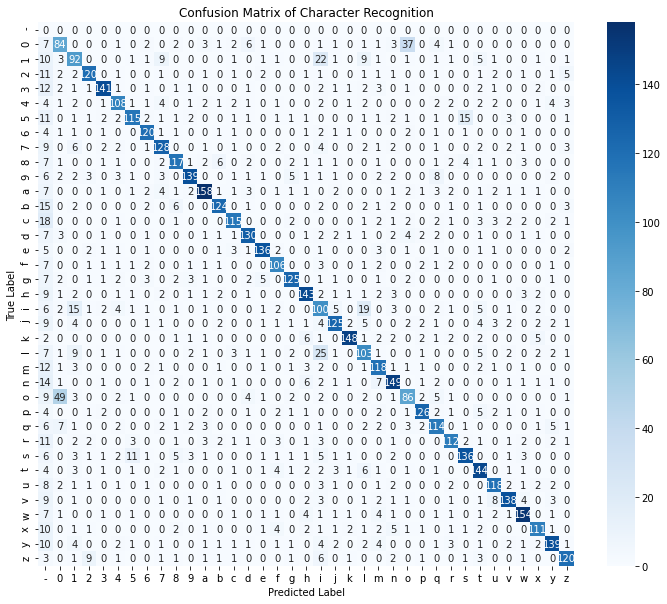

              precision    recall  f1-score   support

           -       0.00      0.00      0.00         0
           0       0.51      0.53      0.52       158
           1       0.57      0.56      0.57       163
           2       0.83      0.76      0.79       157
           3       0.87      0.80      0.83       177
           4       0.77      0.72      0.74       151
           5       0.82      0.68      0.75       168
           6       0.82      0.85      0.84       141
           7       0.78      0.75      0.77       170
           8       0.79      0.74      0.76       158
           9       0.87      0.76      0.81       184
           a       0.84      0.79      0.81       201
           b       0.84      0.77      0.80       162
           c       0.83      0.72      0.77       159
           d       0.82      0.79      0.80       165
           e       0.88      0.83      0.86       163
           f       0.80      0.79      0.79       134
           g       0.85    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_on_unseen_data_with_confusion_matrix(unseen_dir, model, num_images=20):
    """Evaluate the model on the first `num_images` from the unseen directory and display a confusion matrix."""
    correct_predictions = 0
    total_images = 0
    y_true = []  # List to store true labels
    y_pred = []  # List to store predictions

    # Get the first `num_images` files from the directory
    all_files = np.array([f for f in os.listdir(unseen_dir) if f.endswith('.png')])

    # Shuffle the files
    np.random.seed(42)
    np.random.shuffle(all_files)
    all_files = all_files[:num_images]

    for filename in all_files:
        # Extract the true label from the filename (e.g., '2d76' from '2d76-0.png')
        true_label = filename.split('-')[0]

        # Get the full path to the image
        image_path = os.path.join(unseen_dir, filename)

        # Predict the CAPTCHA string
        predicted_string = predict_captcha_string(image_path, model)
        print(f"True: {true_label}, Predicted: {predicted_string}")
        
        # Compare the predicted string with the true label
        if predicted_string == true_label:
            correct_predictions += 1

        # Adjust the predicted string length to match the true label length
        if len(predicted_string) < len(true_label):
            predicted_string = predicted_string.ljust(len(true_label), '-')  # Pad with '-' if shorter
        else:
            predicted_string = predicted_string[:len(true_label)]  # Truncate if longer
        
        # Add each character prediction and true label to lists for confusion matrix calculation
        y_true.extend(true_label)
        y_pred.extend(predicted_string)

        total_images += 1

    # Calculate overall accuracy
    accuracy = correct_predictions / total_images * 100
    print(f"\nAccuracy on the first {num_images} images: {accuracy:.2f}%")

    # Generate and display the confusion matrix
    labels = sorted(CHAR_SET + "-")  # All characters and padding character
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix of Character Recognition")
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=labels))

unseen_dir = TEST_DATASET_PATH
evaluate_on_unseen_data_with_confusion_matrix(unseen_dir, model, 1000)



Exploration - Decision Tree model

In [40]:
# # Exploration - Decision Tree model

# import os
# import numpy as np
# import pandas as pd
# import cv2
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # Preprocessing function to flatten images into vectors
# def preprocess_image(image_path):
#     img = load_img(image_path, color_mode='grayscale')
#     img = img.resize((256, 64))
#     img_array = img_to_array(img) / 255.0  # Normalize pixel values
#     return img_array.flatten()  # Flatten the image into a 1D array

# # Load data and labels, convert images into vectors
# def load_and_preprocess_data(data_path):
#     data, labels = [], []
#     for filename in os.listdir(data_path):
#         label = filename.split('-')[0]
#         image_path = os.path.join(data_path, filename)
#         img_vector = preprocess_image(image_path)
#         data.append(img_vector)
#         labels.append(label)
#     return np.array(data), np.array(labels)

# # Load training and testing data
# x_train, y_train = load_and_preprocess_data(TRAIN_DATASET_PATH)
# x_test, y_test = load_and_preprocess_data(TEST_DATASET_PATH)

# print(f'Training data shape: {x_train.shape}, Training labels: {len(y_train)}')
# print(f'Testing data shape: {x_test.shape}, Testing labels: {len(y_test)}')


Training data shape: (8010, 16384), Training labels: 8010
Testing data shape: (2000, 16384), Testing labels: 2000


In [41]:
# # Encode labels as integers
# from sklearn.preprocessing import LabelEncoder

# # Fit the label encoder using only the labels present in y_train
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)

# # Encode the training labels
# y_train_encoded = np.array(label_encoder.transform(y_train), dtype=np.int32)

# # Define a mapping for unknown labels
# unknown_label_index = len(label_encoder.classes_)

# # Encode test labels, mapping unseen labels to the "unknown" class index
# y_test_encoded = np.array([
#     label_encoder.transform([label])[0] if label in label_encoder.classes_ else unknown_label_index
#     for label in y_test
# ], dtype=np.int32)

# # Ensure x_train and x_test are numpy arrays of floats for model compatibility
# x_train = np.array(x_train, dtype=np.float32)
# x_test = np.array(x_test, dtype=np.float32)

# # Train the Decision Tree as before
# decision_tree = DecisionTreeClassifier(max_depth=12, random_state=42)
# decision_tree.fit(x_train, y_train_encoded)

# # Make predictions on the test set
# y_pred_encoded = decision_tree.predict(x_test)

# # Add "unknown" to the classes for decoding
# # Extend the classes with "unknown" for inverse transform to work properly
# label_classes = list(label_encoder.classes_) + ["unknown"]
# y_pred = [label_classes[pred] if pred < len(label_classes) else "unknown" for pred in y_pred_encoded]

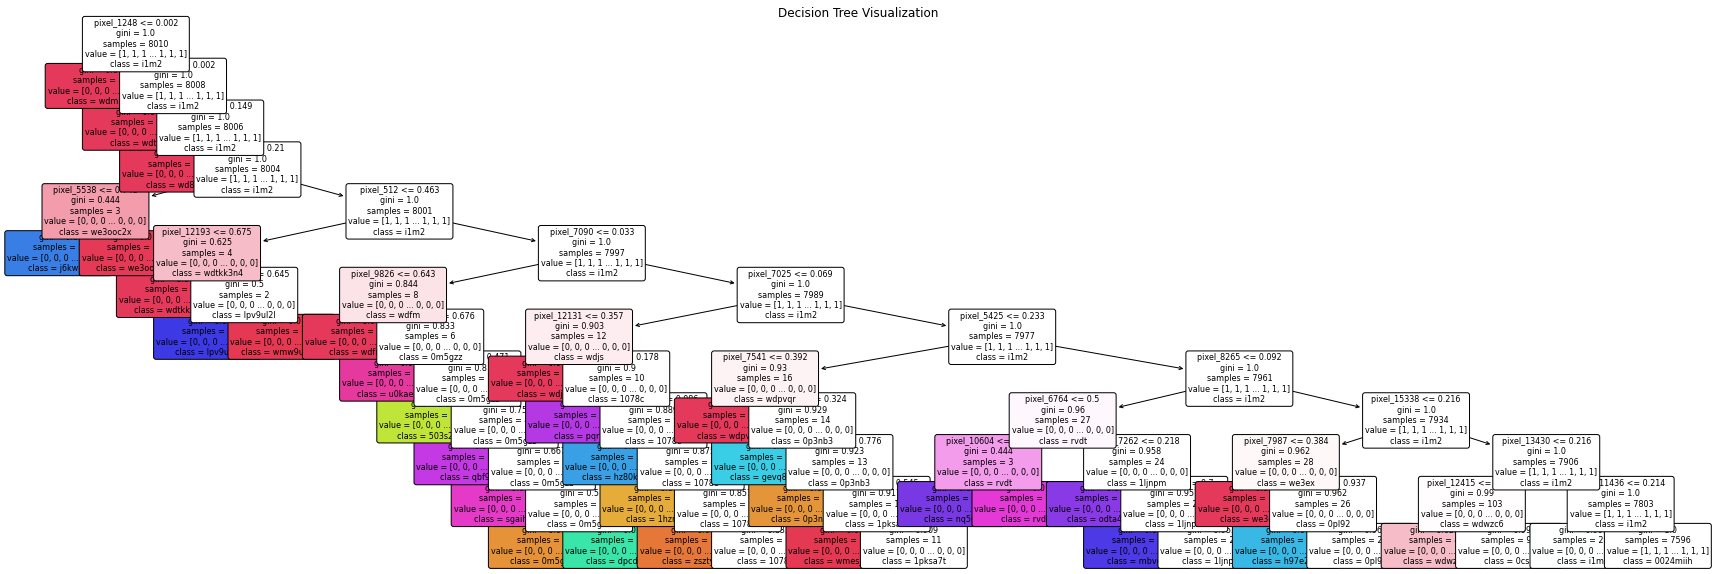

In [42]:

# from sklearn.tree import DecisionTreeClassifier, plot_tree
# import matplotlib.pyplot as plt

# # Visualize the trained decision tree
# plt.figure(figsize=(30, 10)) 
# plot_tree(
#     decision_tree, 
#     feature_names=[f"pixel_{i}" for i in range(x_train.shape[1])],
#     class_names=label_encoder.classes_, 
#     filled=True, 
#     rounded=True, 
#     fontsize=8 
# )
# plt.title("Decision Tree Visualization")
# plt.show()


In [43]:
# def calculate_accuracy(y_true, y_pred):
#     total_chars = 0
#     correct_chars = 0
#     correct_captchas = 0

#     for i in range(len(y_true)):
#         # Compare each predicted CAPTCHA with the ground truth
#         if y_true[i] == y_pred[i]:
#             correct_captchas += 1  # CAPTCHA matches perfectly

#         # Calculate character-wise accuracy
#         for j in range(min(len(y_true[i]), len(y_pred[i]))):
#             total_chars += 1
#             if y_true[i][j] == y_pred[i][j]:
#                 correct_chars += 1

#     captcha_accuracy = correct_captchas / len(y_true)
#     char_accuracy = correct_chars / total_chars

#     return captcha_accuracy, char_accuracy


# # Calculate accuracy
# captcha_acc, char_acc = calculate_accuracy(y_test, y_pred)
# print(f"CAPTCHA Accuracy: {captcha_acc * 100:.2f}%")
# print(f"Character Accuracy: {char_acc * 100:.2f}%")

# # Compare predictions with ground truth
# for i in range(5):
#     print(f'Prediction: {y_pred[i]}, Ground Truth: {y_test[i]}')

CAPTCHA Accuracy: 0.00%
Character Accuracy: 2.51%
Prediction: 0024miih, Ground Truth: 002e23
Prediction: 0024miih, Ground Truth: 03yl9s
Prediction: 0024miih, Ground Truth: 03yuav5
Prediction: 0024miih, Ground Truth: 03zl9o
Prediction: 0024miih, Ground Truth: 04zqohgi
